## Stable diffusion model exploration


### Import Packages and Libraries

In [1]:
! pip install -q --upgrade transformers diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 22.9 MB/s eta 0:00:00


In [2]:
import os
import torch
import PIL
from PIL import Image
from diffusers import StableDiffusionPipeline, DiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
import numpy as np
import cv2
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T
import gc
import torch.nn.functional as F
from torchvision.transforms import v2

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ERA_V1/Session20/dev4

Mounted at /content/drive/
/content/drive/MyDrive/ERA_V1/Session20/dev4


In [4]:
from utils import generate_pil_images, image_grid, cache_cleanup
from custom_loss import compute_loss

In [5]:
# configurations
torch_device        = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
height, width       = 512, 512
guidance_scale      = 8
loss_scale          = 200
num_inference_steps = 50
batch_size          = 1

In [6]:
pretrained_model_path = "CompVis/stable-diffusion-v1-4"
sd_pipeline = DiffusionPipeline.from_pretrained(
    pretrained_model_path,
    torch_dtype=torch.float32
).to(torch_device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


### Functions

In [7]:
def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = sd_pipeline.vae.decode(latents).sample

    pil_images = generate_pil_images(image)

    return pil_images

In [8]:
def generate_image(seed, prompt, loss_type, loss_flag=False):

    generator           = torch.manual_seed(seed)

    # scheduler
    scheduler    = LMSDiscreteScheduler(beta_start = 0.00085, beta_end = 0.012, beta_schedule = "scaled_linear", num_train_timesteps = 1000)
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

    # text embeddings of the prompt
    text_input = sd_pipeline.tokenizer(prompt, padding='max_length', max_length = sd_pipeline.tokenizer.model_max_length, truncation= True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)

    with torch.no_grad():
        text_embeddings = sd_pipeline.text_encoder(text_input.input_ids.to(torch_device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = sd_pipeline.tokenizer(
          [""] * batch_size, padding="max_length", max_length= max_length, return_tensors="pt"
    )

    with torch.no_grad():
        uncond_embeddings = sd_pipeline.text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings,text_embeddings]) # shape: 2,77,768

    # random latent
    latents = torch.randn(
        (batch_size, sd_pipeline.unet.config.in_channels, height// 8, width //8),
        generator = generator,
    ) .to(torch.float32)


    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    for i, t in tqdm(enumerate(scheduler.timesteps), total = len(scheduler.timesteps)):

        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        with torch.no_grad():
            noise_pred = sd_pipeline.unet(latent_model_input.to(torch.float32), t, encoder_hidden_states=text_embeddings)["sample"]

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        if loss_flag and i%5 == 0:

            latents = latents.detach().requires_grad_()
            # the following line alone does not work, it requires change to reduce step only once
            # hence commenting it out
            #latents_x0 = scheduler.step(noise_pred,t, latents).pred_original_sample
            latents_x0 = latents - sigma * noise_pred

            # use vae to decode the image
            denoised_images = sd_pipeline.vae.decode((1/ 0.18215) * latents_x0).sample / 2 + 0.5 # range(0,1)

            loss = compute_loss(denoised_images,loss_type, torch_device) * loss_scale
            #loss = loss.to(torch.float16)
            print(f"{i} loss {loss}")

            cond_grad = torch.autograd.grad(loss, latents)[0]
            latents = latents.detach() - cond_grad * sigma**2

        latents = scheduler.step(noise_pred,t, latents).prev_sample

    return latents

In [9]:
# Load Stable-Diffusion concepts (Styles)
sd_concepts_list = ['<illustration_style>', '<line-art>', '<hitokomoru-style>', ' <Marc_Allante>', '<midjourney-style>', '<hanfu-anime-style>', '<birb_style>']

sd_pipeline.load_textual_inversion("sd-concepts-library/illustration-style")
sd_pipeline.load_textual_inversion("sd-concepts-library/line-art")
sd_pipeline.load_textual_inversion("sd-concepts-library/hitokomoru-style-nao")
sd_pipeline.load_textual_inversion("sd-concepts-library/style-of-marc-allante")
sd_pipeline.load_textual_inversion("sd-concepts-library/midjourney-style")
sd_pipeline.load_textual_inversion("sd-concepts-library/hanfu-anime-style")
sd_pipeline.load_textual_inversion("sd-concepts-library/birb-style")

# Define seeds for all the styles
seed_list = [11, 56, 110, 65, 5, 29, 47]

### Prompt-based Images with Styles

In [10]:
prompt  = """Flying bird with prey in the style of"""

In [11]:
def generate_images_in_styles(prompt, loss_flag=False, loss_type='None'):

  latents_collect = []
  for seed, style in zip(seed_list, sd_concepts_list):
      print("\n***** Style: ", style, " *****")

      # Cleanup cache
      cache_cleanup()

      prompt_with_style = [f'{prompt} {style}']
      latents = generate_image(seed, prompt_with_style, loss_type, loss_flag)
      latents_collect.append(latents)

  # Get prompt-based images in all the styles
  latents_collect = torch.vstack(latents_collect)
  images = latents_to_pil(latents_collect)
  return images, len(latents_collect)


In [40]:
styled_images, count = generate_images_in_styles(prompt, loss_flag=False, loss_type='None')
image_grid(styled_images, 1, count)

Output hidden; open in https://colab.research.google.com to view.

In [41]:
styled_images, count = generate_images_in_styles(prompt, loss_flag=True, loss_type='edge')
image_grid(styled_images, 1, count)

Output hidden; open in https://colab.research.google.com to view.

In [42]:
styled_images, count = generate_images_in_styles(prompt, loss_flag=True, loss_type='contrast')
image_grid(styled_images, 1, count)

Output hidden; open in https://colab.research.google.com to view.

In [43]:
styled_images, count = generate_images_in_styles(prompt, loss_flag=True, loss_type='sharpness')
image_grid(styled_images, 1, count)

Output hidden; open in https://colab.research.google.com to view.


***** Style:  <illustration_style>  *****


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 75.44413757324219
5 loss 48.420501708984375
10 loss 40.861629486083984
15 loss 38.34158706665039
20 loss 36.87743377685547
25 loss 35.576141357421875
30 loss 35.06940460205078
35 loss 34.56098937988281
40 loss 34.11610794067383
45 loss 33.57898712158203

***** Style:  <line-art>  *****


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 90.46829223632812
5 loss 23.033634185791016
10 loss 28.900596618652344
15 loss 21.558687210083008
20 loss 21.068004608154297
25 loss 19.974773406982422
30 loss 19.352781295776367
35 loss 19.01151466369629
40 loss 18.582143783569336
45 loss 18.142805099487305

***** Style:  <hitokomoru-style>  *****


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 72.68500518798828
5 loss 21.142148971557617
10 loss 40.266876220703125
15 loss 31.985769271850586
20 loss 31.75946807861328
25 loss 28.93149185180664
30 loss 27.500808715820312
35 loss 27.183944702148438
40 loss 26.874515533447266
45 loss 26.985008239746094

***** Style:   <Marc_Allante>  *****


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 81.77120971679688
5 loss 29.094623565673828
10 loss 29.16823387145996
15 loss 32.61447525024414
20 loss 29.881132125854492
25 loss 28.333526611328125
30 loss 26.758766174316406
35 loss 25.63511085510254
40 loss 24.841096878051758
45 loss 24.471412658691406

***** Style:  <midjourney-style>  *****


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 104.54837036132812
5 loss 66.67069244384766
10 loss 43.91645050048828
15 loss 39.40729522705078
20 loss 37.05977249145508
25 loss 35.31475830078125
30 loss 33.824134826660156
35 loss 33.27557373046875
40 loss 32.80160903930664
45 loss 32.30517578125

***** Style:  <hanfu-anime-style>  *****


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 36.71694564819336
5 loss 128.0579376220703
10 loss 107.53301239013672
15 loss 97.86576843261719
20 loss 93.5386734008789
25 loss 91.87672424316406
30 loss 90.88421630859375
35 loss 90.14282989501953
40 loss 89.63601684570312
45 loss 89.23338317871094

***** Style:  <birb_style>  *****


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 119.12140655517578
5 loss 38.21229934692383
10 loss 30.818038940429688
15 loss 26.131486892700195
20 loss 25.1033992767334
25 loss 23.876543045043945
30 loss 23.015291213989258
35 loss 22.380863189697266
40 loss 21.946514129638672
45 loss 21.753646850585938


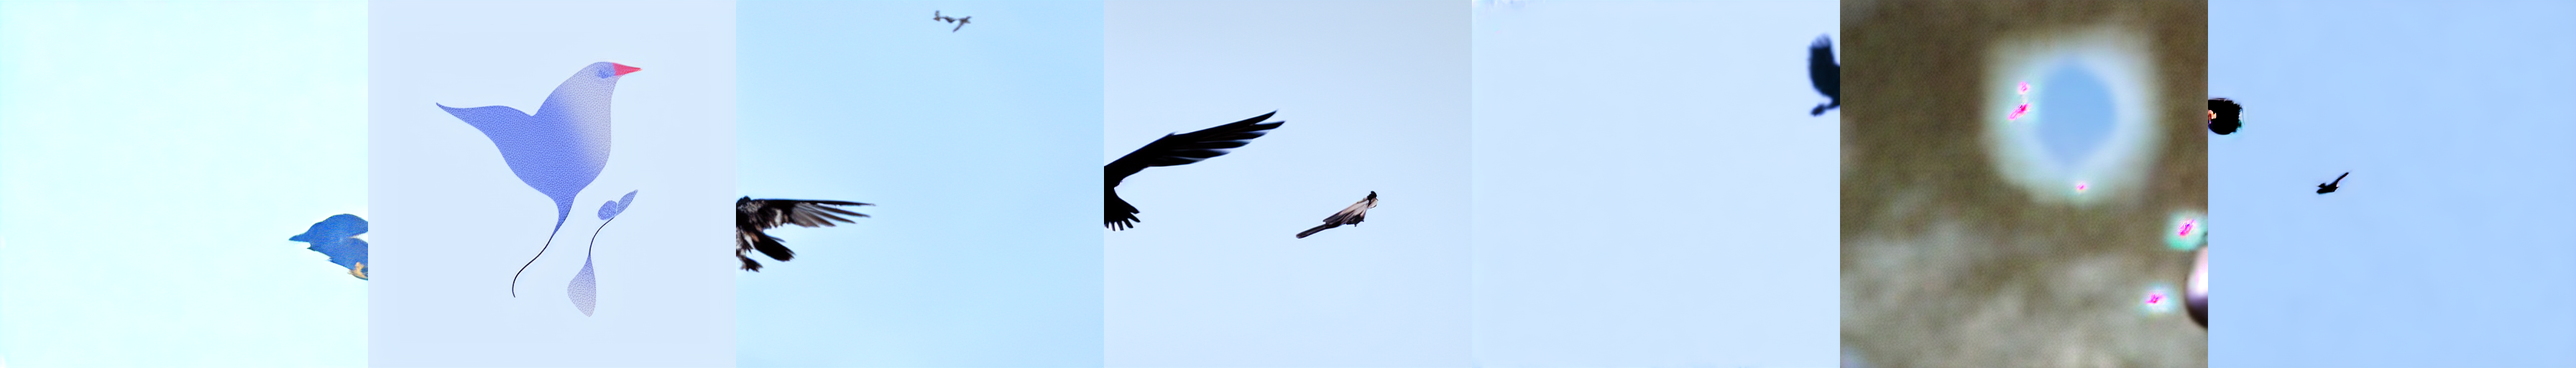

In [44]:
styled_images, count = generate_images_in_styles(prompt, loss_flag=True, loss_type='blue')
image_grid(styled_images, 1, count)

In [45]:
styled_images, count = generate_images_in_styles(prompt, loss_flag=True, loss_type='brightness')
image_grid(styled_images, 1, count)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
prompt2  = """Cats fighting on the road in the style of"""

In [15]:
styled_images, count = generate_images_in_styles(prompt2, loss_flag=True, loss_type='edge')
image_grid(styled_images, 1, count)

Output hidden; open in https://colab.research.google.com to view.